In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import json
import seaborn as sns
from scipy.stats import ttest_1samp
import re
import operator

In [22]:
config = json.load(open('../config.json', 'r'))
INPUT_DIR = config['INPUT_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']

In [17]:
events = open(INPUT_DIR + 'event_names.txt', 'r').read().splitlines()
shooter_race = json.load(open(INPUT_DIR + "shooters_race.json","r"))

In [4]:
def get_df(word):
    log_odds_list = []
    vocab_size = []
    event_names = []
    race = []
    for e in events:
        # format name
        name = ' '.join(s[0].upper() + s[1:] for s in e.split('_'))
        log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds.npy')
        vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
        words2idx = {w: i for i, w in enumerate(vocab)}
    
        # keep words / phrases if they occur at least ten times
        vocab_log_odds = {w: log_odds[3,i] for i, w in enumerate(vocab) if log_odds[0,i]>10}
        if word not in vocab_log_odds:
            print('missing:', name)
            continue
        
        event_names.append(name)
        vocab_size.append(log_odds.shape[1])
        log_odds_list.append(vocab_log_odds[word])
        print(name)
        race.append(shooter_race[e])
    df = pd.DataFrame.from_dict({'event': event_names, 'log_odds':log_odds_list, 'vocab_size':vocab_size, 'race':race})
    df.sort_values('vocab_size', ascending=False, inplace=True)
    print(df)
    return df

In [5]:
terr = get_df('terrorist')
terr['word'] = '"terrorist"'
craz = get_df('crazi')
craz['word'] = '"crazy"'
concat = pd.concat([terr, craz], ignore_index=True)

Chattanooga
Roseburg
Colorado Springs
San Bernardino
Kalamazoo
Orlando
Dallas
Baton Rouge
Burlington
Fort Lauderdale
Fresno
missing: San Francisco
Vegas
Thornton
Sutherland Springs
Parkland
Nashville
Santa Fe
Annapolis
Pittsburgh
Thousand Oaks
                 event  log_odds  vocab_size   race
5              Orlando  0.308304       36966    POC
11               Vegas -0.264375       26604  white
14            Parkland -0.098483        9893  white
6               Dallas  0.168449        5872    POC
13  Sutherland Springs -0.150524        4531  white
19       Thousand Oaks -0.246098        3120  white
16            Santa Fe -0.205688        3016  white
18          Pittsburgh -0.195706        2023  white
3       San Bernardino  0.184183        2010    POC
15           Nashville -0.325540        1733  white
2     Colorado Springs -0.254366        1620  white
7          Baton Rouge  0.279134        1333    POC
17           Annapolis -0.232415        1248  white
0          Chattanooga  0.09

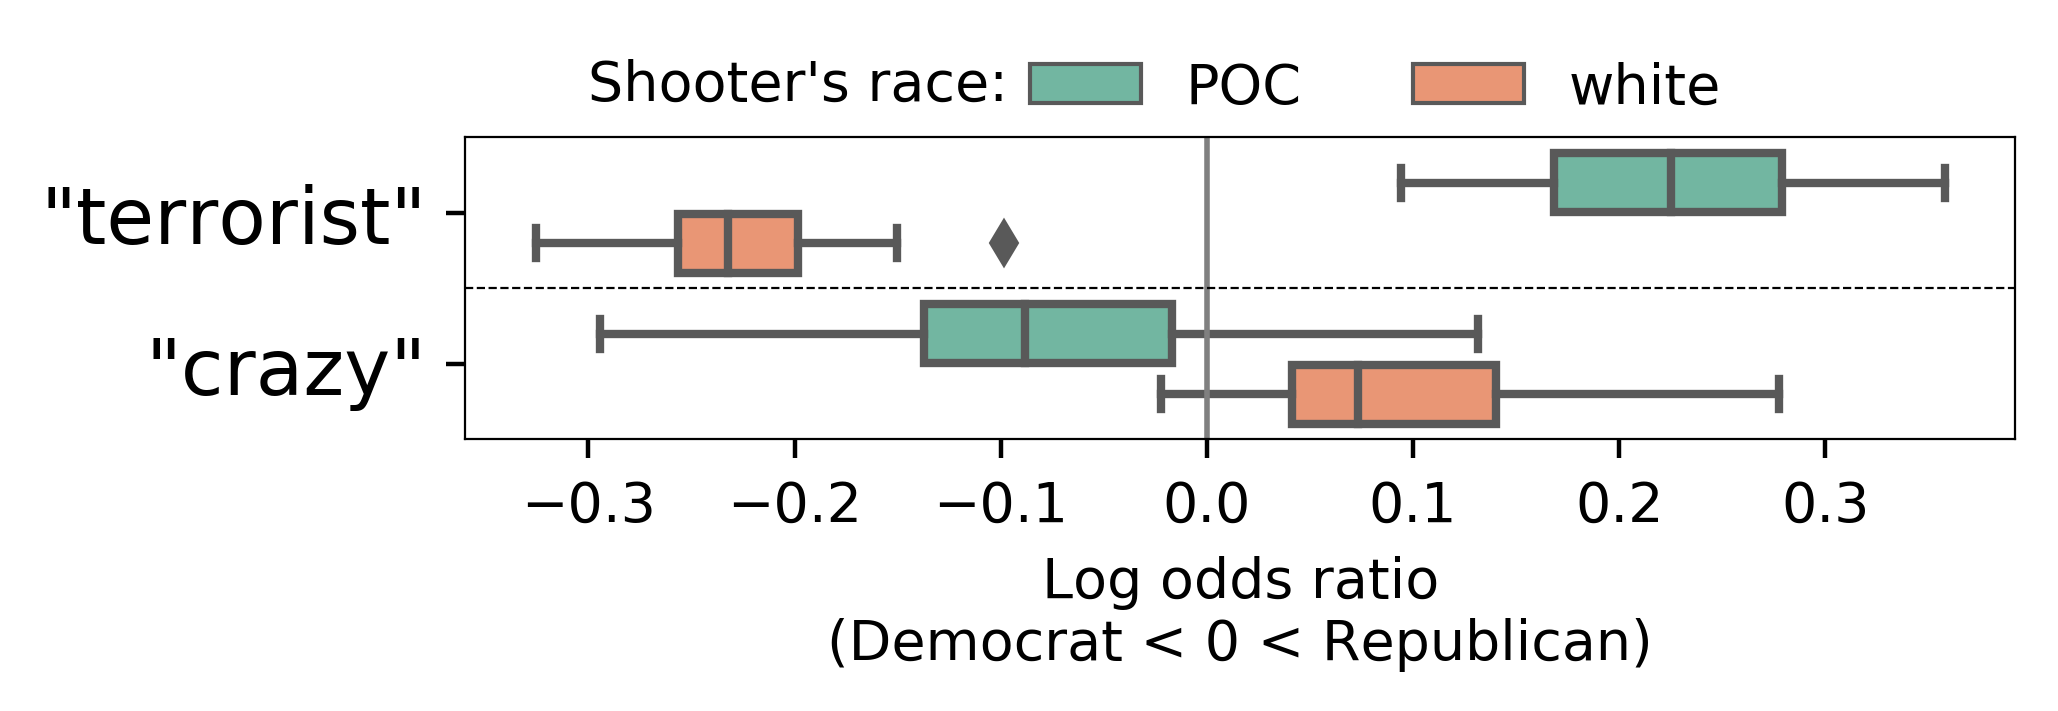

In [48]:
f = plt.figure(dpi=400, figsize=(5,1))
ax = sns.boxplot(data=concat, x="log_odds",y='word', hue="race", orient="h", palette=sns.color_palette("Set2", 2))
plt.axvline(x=0, color='grey', linewidth=1)
plt.axhline(y=0.5, color='black', linewidth=.4, linestyle='--')
ax.set_ylabel("")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
plt.yticks(fontsize=14)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
ax.text(-.3,-0.75, "Shooter's race:")
l = ax.legend(bbox_to_anchor=(.35, 1), loc=3, borderaxespad=0., ncol=2, frameon=False)
#l.set_title("Shooter's race")

In [ ]:
f = plt.figure(dpi=400, figsize=(5,1))
ax = sns.boxplot(data=df, x="log_odds",y='race', orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.plot([0,0], [-1, 20], linewidth=1, color='grey')
ax.set_ylabel("Shooter's race")
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
ax.set_xlabel('Log odds ratio of "'+word+'"\n(Democrat < 0 < Republican)')

In [12]:
for i, g in df.groupby('race'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

POC
Ttest_1sampResult(statistic=-1.7660822681325092, pvalue=0.12072527692513597)
white
Ttest_1sampResult(statistic=3.6709396041707842, pvalue=0.004310419549140847)


## Find words whose use differs the most depending on the shooter's race

In [16]:
# get all words that are not missing from more than three events
no_events = len(events)
shared_vocab = {}
for e in events:
    vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
    for w in vocab:
        if w in shared_vocab:
            shared_vocab[w] += 1
        else:
            shared_vocab[w] = 1
shared_vocab = [k for k, v in shared_vocab.items() if v > (no_events-4)]

In [18]:
len(shared_vocab)

195

In [26]:
def get_val(vals):
    return np.abs(np.mean(vals))

In [27]:
words = []
differences = []
for w in shared_vocab:
    print(w)
    odds_white = []
    odds_poc = []
    for e in events:
        # format name
        log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds.npy')
        vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
        words2idx = {w: i for i, w in enumerate(vocab)}
    
        # keep words / phrases if they occur at least ten times
        vocab_log_odds = {w: log_odds[3,i] for i, w in enumerate(vocab) if log_odds[0,i]>10}
    
        if w not in vocab_log_odds:
            continue
        if shooter_race[e] == 'white':
            odds_white.append(vocab_log_odds[w])
        else:
            odds_poc.append(vocab_log_odds[w])
        
    words.append(w)
    
    differences.append(get_val(odds_white) * get_val(odds_poc) * (np.sign(np.mean(odds_white)) - np.sign(np.mean(odds_poc))))
df = pd.DataFrame.from_dict({'word': words, 'difference': differences})
print(df)

kill
shooter
famili
victim
attack
gun
4
prayer
shoot
today
terror
terrorist
obama
muslim
thought
shot
gunman
offic
peopl
dead
report
pray
thought prayer
call
news
act
live
polic
white
5
arm
die
heart
2
time
american
day
happen
free
break
god
victim famili
peac
sad
1
activ
media
friend
make
stop
blame
motiv
home
suspect
affect
offici
murder
america
law
injur
love
violenc
man
lost
work
activ shooter
prayer victim
countri
state
killer
hear
fire
guy
#break
mass
confirm
week
citi
wound
show
tweet
tragedi
cnn
control
good
talk
3
watch
involv
give
famili victim
yesterday
wait
identifi
thing
secur
place
death
incid
respons
gun control
support
updat
situat
ap
hate
press
fuck
back
start
morn
target
hope
word
mental
world
end
year
stori
care
heard
send
person
close
find
coverag
great
feel
safe
latest
rt
local
life
problem
tonight
innoc
guess
detail
read
bad
fox
crazi
open
scene
multipl
9
black
minut
post
issu
left
fact
real
shot kill
shit
wrong
crime
area
hour
hey
break news
check
hurt
lot
ppl
tw

In [28]:
df.sort_values('difference', ascending=False)

,word,difference
141,crazi,0.015278
129,latest,0.013421
175,#shoot,0.011996
188,fatal,0.011238
66,prayer victim,0.010767
142,open,0.010667
163,lot,0.009998
137,detail,0.009522
73,#break,0.009487
184,open fire,0.009369


In [29]:
df.sort_values('difference', ascending=True)

,word,difference
11,terrorist,-0.097423
13,muslim,-0.028964
10,terror,-0.026577
23,call,-0.010966
136,guess,-0.008052
159,hey,-0.005957
28,white,-0.005785
146,black,-0.005465
174,mention,-0.000794
187,shooter kill,-0.000725


# produce LaTeX for appendix

In [20]:
for e in events:
    name = ' '.join(s[0].upper() + s[1:] for s in e.split('_'))
    log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds_normed.npy')
    vocab = open(TWEET_DIR+e+'/'+e+'_vocab.txt', 'r').read().splitlines()
    words2idx = {w: i for i, w in enumerate(vocab)}
    
    # keep words / phrases if they occur at least ten times
    vocab_log_odds = {w: log_odds[3,i] for i, w in enumerate(vocab) if log_odds[0,i]>10}
    sorted_x = sorted(vocab_log_odds.items(), key=operator.itemgetter(1))
    print('\\paragraph{%s.}' %name)
    print('\\emph{Most Republican phrases:} ', ', '.join([k + ' (%.2f)' %v for k, v in reversed(sorted_x[-20:])]).replace('#', '\#'),'\\\\')
    print('\emph{Most Democrat phrases:} ', ', '.join([k + ' (%.2f)' %v for k, v in sorted_x[:20]]).replace('#', '\#'))

\paragraph{Chattanooga.}
\emph{Most Republican phrases:}  obama (7.41), gun free (5.89), zone (5.70), free (5.69), free zone (5.53), flag (5.33), \#tcot (5.33), \#chattanoogaattack (5.13), \#wakeupamerica (4.94), islam (4.69), \#obama (4.01), \#islam (3.83), attack (3.67), \#gunfreezon (3.66), lower (3.66), liber (3.54), arm (3.44), workplac (3.32), white hous (3.23), workplac violenc (3.21) \\
\emph{Most Democrat phrases:}  blame georg (-8.62), bush invad (-8.62), invad iraq (-8.60), invad (-8.60), base lie (-8.55), georg bush (-8.53), war base (-8.51), lie happen (-8.51), georg (-8.35), iraq war (-8.31), iraq (-8.24), bush (-7.77), lie (-7.45), \#charleston (-6.99), mass (-6.82), \#lafayett (-6.48), happen (-6.19), \#charlestonshoot (-5.96), blame (-5.40), \#gunsens (-5.09)
\paragraph{Roseburg.}
\emph{Most Republican phrases:}  obama (8.02), \#2a (6.28), \#obama (6.01), gun free (5.37), \#tcot (5.32), free (5.22), christian (5.09), zone (5.08), chicago (5.06), shooter (4.78), free zo

\paragraph{Thousand Oaks.}
\emph{Most Republican phrases:}  california (16.51), zone (12.80), free (12.40), gun free (12.22), free zone (11.80), bar (9.98), california bar (9.61), strictest (9.01), strictest gun (8.52), men (7.63), \#foxnew (7.33), killer ian (7.12), california strictest (7.11), fear resid (7.11), report killer (7.08), prayer massacr (7.04), communist (7.04), long mock (7.00), mock hope (6.80), ian long (6.77) \\
\emph{Most Democrat phrases:}  inact (-17.50), pattern (-17.46), pattern inact (-17.45), shoot pattern (-17.43), shoot (-16.92), januari (-13.09), inact januari (-12.92), \#guncontrolnow (-8.09), mass shoot (-7.89), day (-7.34), fuck (-6.94), nra (-6.94), violenc (-6.71), mother (-6.64), mass (-6.59), thought (-6.44), high (-6.37), januar (-6.22), inact januar (-6.15), \#potus (-6.05)


In [28]:
cluster_names = {0: "shooter's identity\n& ideology",
 1: 'news',
 2: 'victims & location',
 3: 'laws & policy',
 4: 'investigation',
 5: 'solidarity',
 6: 'remembrance',
 7: 'other'}

cluster_colors = {0: 'F2D7D5',
                  1: 'FCF3CF',
                  2: 'EAEDED',
                  3: 'D0ECE7',
                  4: 'D6EAF8',
                  5: 'EBDEF0',
                  6: 'D7FFCE',
                  7: 'FFE8DD'
}
print('\\begin{table}[]')
print('\\centering')
print('\\begin{tabular}{|l|}')
print('\\hline')
print('\\textbf{Topic colors} \\\\ \\hline')
for i in range(NUM_CLUSTERS):
    print('\\rowcolor[HTML]{'+cluster_colors[i] +'}')
    print(cluster_names[i], '\\\\ \\hline')
print('\\end{tabular}')
print('\\end{table}')

    

for e in events:
    name = ' '.join(s[0].upper() + s[1:] for s in e.split('_'))
    print('\\begin{table*}[!h]')
    print('\\centering')
    print('\\resizebox{\linewidth}{!}{%')

    print('\\begin{tabular}{|l|l|}')
    
    
    print('\\hline')
    print('Republican & Democrat\\\\ \\hline')
    log_odds = np.load(TWEET_DIR +e+'/'+e+'_vocab_log_odds_topics.npy')
    vocab = open(TWEET_DIR +e+'/'+e+'_vocab.txt', 'r').read().splitlines()
    words2idx = {w: i for i, w in enumerate(vocab)}
    for j in range(NUM_CLUSTERS):
        print('\\rowcolor[HTML]{'+cluster_colors[j] +'}')
        vocab_log_odds = {w: log_odds[j,3,i] for i, w in enumerate(vocab) if log_odds[j,0,i]>10}
        sorted_x = sorted(vocab_log_odds.items(), key=operator.itemgetter(1))

        print(', '.join([k + ' (%.2f)' %v for k, v in reversed(sorted_x[-5:])]).replace('#', '\#'), '&', ', '.join([k + ' (%.2f)' %v for k, v in sorted_x[:5]]).replace('#', '\#'), '\\\\')
        print('\\hline')
    print('\\end{tabular} %')
    print('}')
    print('\\caption{Most partisan phrases per topic for \\textbf{'+name+'}. Brackets show the $z$-scores of the log odds of each phrase.}')
    print('\\end{table*}')

\begin{table}[]
\centering
\begin{tabular}{|l|}
\hline
\textbf{Topic colors} \\ \hline
\rowcolor[HTML]{F2D7D5}
shooter's identity
& ideology \\ \hline
\rowcolor[HTML]{FCF3CF}
news \\ \hline
\rowcolor[HTML]{EAEDED}
victims & location \\ \hline
\rowcolor[HTML]{D0ECE7}
laws & policy \\ \hline
\rowcolor[HTML]{D6EAF8}
investigation \\ \hline
\rowcolor[HTML]{EBDEF0}
solidarity \\ \hline
\rowcolor[HTML]{D7FFCE}
remembrance \\ \hline
\rowcolor[HTML]{FFE8DD}
other \\ \hline
\end{tabular}
\end{table}
\begin{table*}[!h]
\centering
\resizebox{\linewidth}{!}{%
\begin{tabular}{|l|l|}
\hline
Republican & Democrat\\ \hline
\rowcolor[HTML]{F2D7D5}
\#obama (0.45), toler (0.45), presid (0.45), \#wakeupamerica (0.45), celebr (0.45) & blame georg (-0.94), invad iraq (-0.94), bush invad (-0.94), iraq war (-0.94), base lie (-0.94) \\
\hline
\rowcolor[HTML]{FCF3CF}
zone (0.35), fox news (0.34), 5th victim (0.33), \#tcot (0.33), class (0.32) & mass (-0.68), \#prayforchattanooga (-0.37), horrif (-0.37), \#break

\#americafirst (0.80), killari (0.80), told word (0.80), carri terror (0.80), \#buildthewal (0.80) & learn hate (-0.59), hint wasn (-0.59), hate hint (-0.59), wasn osama (-0.59), shot girl (-0.59) \\
\hline
\end{tabular} %
}
\caption{Most partisan phrases per topic for \textbf{Orlando}. Brackets show the $z$-scores of the log odds of each phrase.}
\end{table*}
\begin{table*}[!h]
\centering
\resizebox{\linewidth}{!}{%
\begin{tabular}{|l|l|}
\hline
Republican & Democrat\\ \hline
\rowcolor[HTML]{F2D7D5}
ag lynch (0.45), doj (0.45), lectur (0.45), \#maga (0.45), \#dallaspoliceshoot \#bluelivesmatt (0.45) & \#disarmh (-0.90), communiti color (-0.90), \#disarmh address (-0.90), address \#gunviol (-0.90), 2 \#disarmh (-0.90) \\
\hline
\rowcolor[HTML]{FCF3CF}
\#pjnet (0.57), mt prayer (0.57), \#bluelivesmatt \#pjnet (0.57), panther (0.57), \#tcot (0.57) & lawrenc (-0.73), npr (-0.69), bbc (-0.63), \#enough (-0.60), read (-0.58) \\
\hline
\rowcolor[HTML]{EAEDED}
3 (0.36), attack (0.33), \#dalla

injur stand (0.60), impeach postpon (0.60), green trump (0.60), \#dtmag (0.60), stand countri (0.60) & receiv year (-0.79), click full (-0.79), raw stori (-0.79), \#theresist (-0.79), \#bakersfield (-0.79) \\
\hline
\rowcolor[HTML]{FFE8DD}
kain (0.67), tim kain (0.67), kain attack (0.67), room wish (0.67), kaya (0.67) & \#tytliv (-0.72), \#notmypresid (-0.72), senjohnthun (-0.72), prayer stop (-0.72), prayer nice (-0.72) \\
\hline
\end{tabular} %
}
\caption{Most partisan phrases per topic for \textbf{Vegas}. Brackets show the $z$-scores of the log odds of each phrase.}
\end{table*}
\begin{table*}[!h]
\centering
\resizebox{\linewidth}{!}{%
\begin{tabular}{|l|l|}
\hline
Republican & Democrat\\ \hline
\rowcolor[HTML]{F2D7D5}
news (0.60), motiv (0.42), blame (0.34), talk (0.32), tweet (0.31) & live stack (-0.29), furnitur (-0.29), bibl furnitur (-0.29), stack (-0.27), stack bibl (-0.27) \\
\hline
\rowcolor[HTML]{FCF3CF}
detail (0.34), involv (0.34), \#coloradoshoot (0.34), park lot (0.34),